In [1]:
import scipy
import os
import numpy as np
import mne
import matplotlib.pyplot as plt

import utils.variables as v
import utils.valid_recs as vrecs

In [2]:
class Recording:
    # Data paths
    root = 'C:/Users/annej/OneDrive/Documents/GitHub/MASTER-eeg-stress-det'
    dir_raw = root + '/Data/Raw_eeg'
    dir_filtered = root + '/Data/Filtered'
    
    # Parameters
    Fs = 250
    ch_type = 'eeg'
    n_channels = 8
    
    def __init__(self, sub_nr, ses_nr, run_nr):
        self.sub_nr = sub_nr
        self.ses_nr = ses_nr
        self.run_nr = run_nr
        
        # Load data
        self.load_data()
                
        # Create mne RawArray
        info = mne.create_info(8, sfreq=self.Fs, ch_types=self.ch_type, verbose=None)
        #print(info)
        self.raw_arr = mne.io.RawArray(self.data, info)
        
        mne.rename_channels(self.raw_arr.info, v.MAPPING)

        # Do initial filtering
        self.filt_arr = self.init_filter()
        
        # Set montage
        montage = mne.channels.make_standard_montage('standard_1020')
        self.filt_arr.set_montage(montage)   
    #----------------------------------------------------------------------------------------------------
     
    def load_data(self):
        dir = self.dir_raw
        data_key = 'raw_eeg_data'
        # Load one recording
        filename = f"/sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}.mat"
        f = dir + filename
        self.data = scipy.io.loadmat(f)[data_key]

    def save_data(self):
        title = f"sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
        clean_data = self.reconst_arr.to_data_frame(scalings=1e6)
        clean_data = clean_data.to_numpy()
        clean_data = np.transpose(clean_data)
        clean_dict = {
            "Clean_data" : clean_data[1:, :]  #First column of dataFrames is not data
        }
        scipy.io.savemat(f'{self.root}/Data/ICA_data/{title}.mat', clean_dict)

    def save_psd(self):
        title = f"sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
        psd_data = self.psd.get_data()
        psd_dict = {
            "psd_data" : psd_data
        }
        scipy.io.savemat(f'{self.root}/Data/PSD_data/{title}.mat', psd_dict)
    
    
    def init_filter(self):
        self.raw_arr.compute_psd().plot()
        band_pass = self.raw_arr.copy().filter(1, 70)
        #reject = band_pass.copy().filter(52,48, l_trans_bandwidth = 0.1, h_trans_bandwidth = 0.1)
        notch = band_pass.copy().notch_filter(freqs=[50,100], trans_bandwidth = 4)
        #sav_gol = notch.copy().savgol_filter(h_freq=35, verbose=False)
        return notch
    
    def compute_and_save_filtered_psd(self):
        self.psd = self.filt_arr.compute_psd()
        self.psd.plot()
        self.save_psd()


    def init_ICA(self):
        self.ica = mne.preprocessing.ICA(n_components=8, max_iter=10000, random_state=97)
        self.ica.fit(self.filt_arr)
        
    def plot_sources(self):
        self.ica.plot_sources(self.filt_arr, title=f'ICA components sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}', show_scrollbars=False)
        self.ica.plot_components(colorbar=True, reject='auto')
        
    def plot_properties(self, components):
        self.ica.plot_properties(self.filt_arr, picks = components)
        
    def test_exclude(self, components):
        self.ica.plot_overlay(self.filt_arr, exclude=components, picks='eeg', stop = 300.)
        #self.ica.plot_overlay(self.filt_arr, exclude=components, picks='eeg', show = True)
 

    def exclude_ICA(self, components):
        self.ica.exclude = components
        self.reconst_arr = self.filt_arr.copy()
        self.ica.apply(self.reconst_arr)
    
    def plot(self, data_type, save=False):
        if data_type == 'ica' and save == True:
            with mne.viz.use_browser_backend('matplotlib'):
                title = f"ICA components sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                fig = self.ica.plot_sources(self.filt_arr, title=title, 
                                            show_scrollbars=False)
                fig.savefig(f'{self.root}/Figures/{title}.png') 

        else:
            if data_type == 'raw':
                data = self.raw_arr
                title = f"Raw data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                data.compute_psd().plot()
            elif data_type == 'filtered': 
                data = self.filt_arr
                title = f"Filtered data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                data.compute_psd().plot()
            elif data_type == 'reconstructed':
                data = self.reconst_arr
                title = f"Reconstructed data sub-{self.sub_nr}_ses-{self.ses_nr}_run-{self.run_nr}"
                data.compute_psd().plot()
                pass

            if not save:
                data.plot(duration = 25, title=title, n_channels=self.n_channels, scalings=None, show_scrollbars=False)
            else:
                with mne.viz.use_browser_backend('matplotlib'):
                    fig = data.plot(duration = 30, title=f'{title}', n_channels=8, scalings=None, show_scrollbars=False)
                    fig.savefig(f'{self.root}/Figures/{title}.png') 



Creating RawArray with float64 data, n_channels=8, n_times=75072
    Range : 0 ... 75071 =      0.000 ...   300.284 secs
Ready.
Effective window size : 1.024 (s)
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 825 samples (3.300 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition

C:\Users\annej\AppData\Local\Temp\ipykernel_21496\2691519822.py:63: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  self.raw_arr.compute_psd().plot()
c:\Users\annej\anaconda3\envs\MNE\lib\site-packages\mne\viz\utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Do

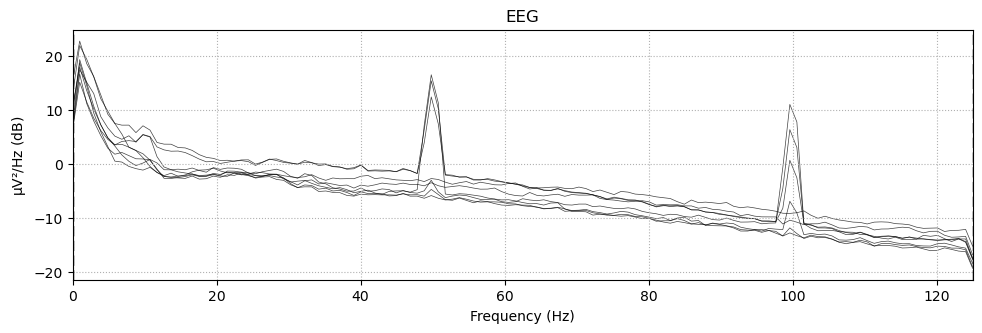

In [3]:
test = Recording(sub_nr='P001', ses_nr='S001', run_nr='001')
#test.compute_and_save_filtered_psd()

In [4]:
#test.plot('raw')
#test.plot('filtered')

In [5]:
#test.compute_and_save_filtered_psd()

In [6]:
#test.init_ICA()
#test.plot_sources()

In [7]:
#test.plot_properties([2])

In [8]:
#test.test_exclude([0,1,2])

In [9]:
#test.exclude_ICA([0,1,2])
#test.plot('filtered')
#test.plot('reconstructed')

In [10]:
#test.plot('raw', save=True)
#test.plot('filtered', save=True)
#test.plot('ica', save=True)
#test.plot('reconstructed', save=True)

In [11]:
#test.save_data()